# Exploratory Data Analysis — CRM Lifecycle Project

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid')  


## Load the datasets

In [8]:
clientes = pd.read_csv('../data/clientes.csv')
transacoes = pd.read_csv('../data/transacoes.csv')
campanhas = pd.read_csv('../data/campanhas.csv')

# Convert date columns
clientes['data_entrada'] = pd.to_datetime(clientes['data_entrada'])
transacoes['data'] = pd.to_datetime(transacoes['data'])
campanhas['data_envio'] = pd.to_datetime(campanhas['data_envio'])

##  Basic overview

In [9]:
print('Clientes:', clientes.shape)
print('Transações:', transacoes.shape)
print('Campanhas:', campanhas.shape)

clientes.head()

Clientes: (500, 7)
Transações: (22688, 4)
Campanhas: (1260, 4)


,cliente_id,nome,idade,renda_mensal,data_entrada,canal_entrada,regiao
0,1,Ana Luiza Carvalho,58,3002.97,2022-06-27,indicação,Sul
1,2,Manuela Pinto,32,3383.76,2022-10-16,orgânico,Norte
2,3,Paulo Ferreira,23,9471.65,2022-11-29,orgânico,Sudeste
3,4,João Lucas Carvalho,23,4451.61,2023-04-10,orgânico,Norte
4,5,Bárbara Costa,30,11166.26,2022-06-27,social,Sul


## Customer demographics

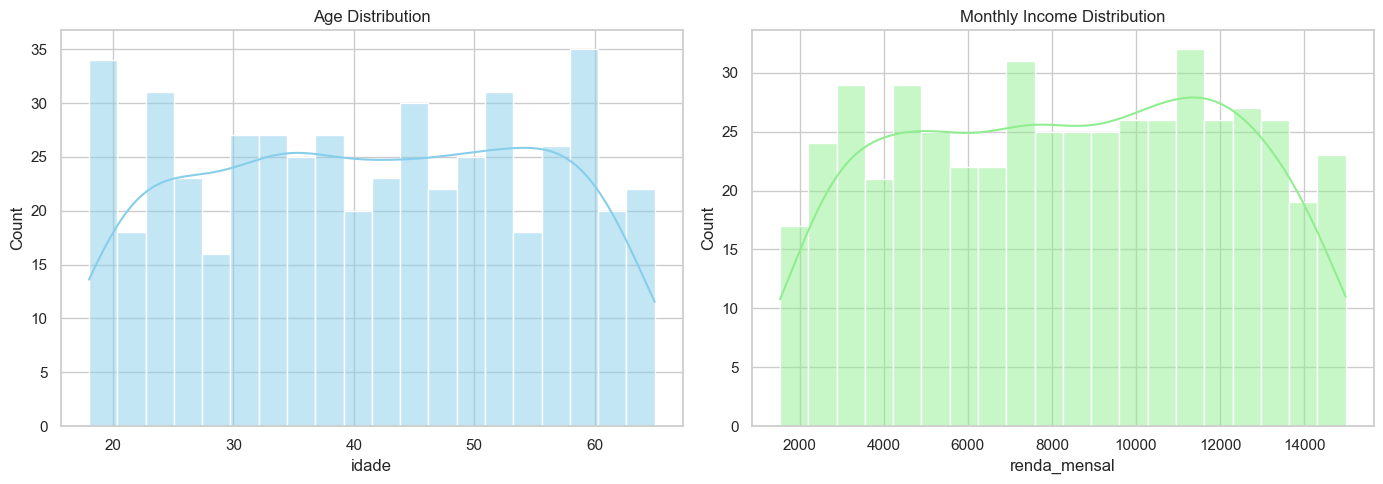

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(clientes['idade'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution')
sns.histplot(clientes['renda_mensal'], bins=20, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Monthly Income Distribution')
plt.tight_layout()
plt.show()

##  RFM Metrics

In [11]:
# Calculate Recency
snapshot_date = transacoes['data'].max() + pd.Timedelta(days=1)
rfm = transacoes.groupby('cliente_id').agg({
    'data': lambda x: (snapshot_date - x.max()).days,
    'cliente_id': 'count',
    'valor': 'sum'
})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()
rfm.head()

,cliente_id,recency,frequency,monetary
0,1,22,53,7457.30
1,2,15,47,6746.84
2,3,18,44,5688.57
3,4,27,23,3310.97
4,5,8,63,8740.16


##  Churn Detection (Simple Rule-based)

In [12]:
# A customer is considered churned if last transaction was > 90 days ago
rfm['churned'] = rfm['recency'] > 90
rfm['churned'].value_counts(normalize=True)

churned
False    1.0
Name: proportion, dtype: float64

### View complement

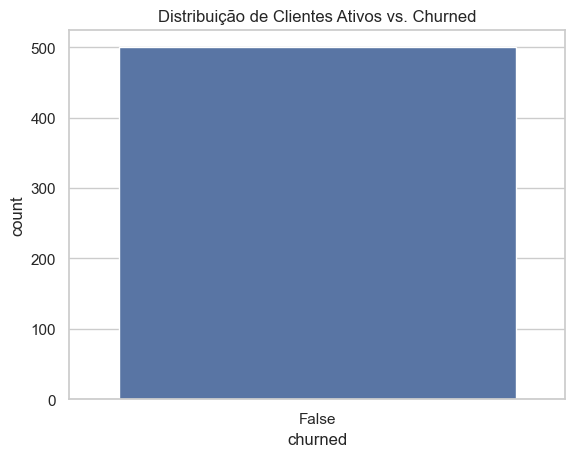

In [13]:
sns.countplot(x='churned', data=rfm)
plt.title("Distribuição de Clientes Ativos vs. Churned")
plt.show()


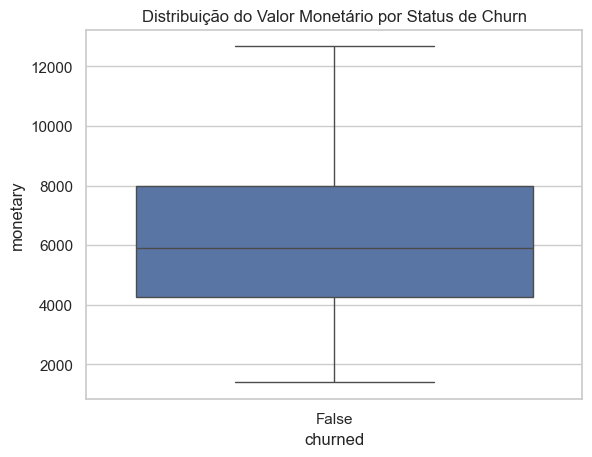

In [18]:
sns.boxplot(x='churned', y='monetary', data=rfm)
plt.title("Distribuição do Valor Monetário por Status de Churn")
plt.show()

### RFM Scoring

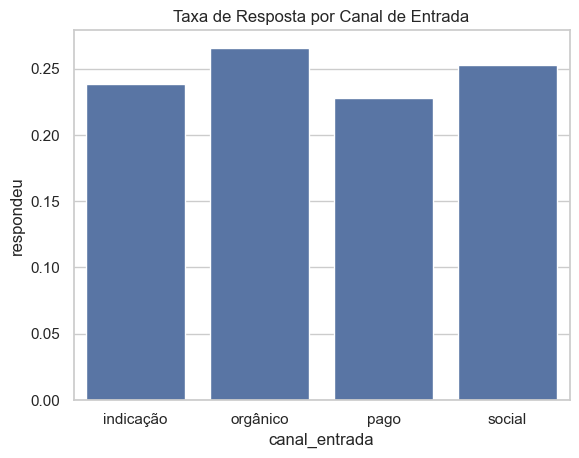

In [32]:
respostas = campanhas.merge(clientes, on='cliente_id')
taxa_resposta = respostas.groupby('canal_entrada')['respondeu'].apply(lambda x: (x == 'sim').mean()).reset_index()
sns.barplot(data=taxa_resposta, x='canal_entrada', y='respondeu')
plt.title('Taxa de Resposta por Canal de Entrada')
plt.show()



### Campaign analysis

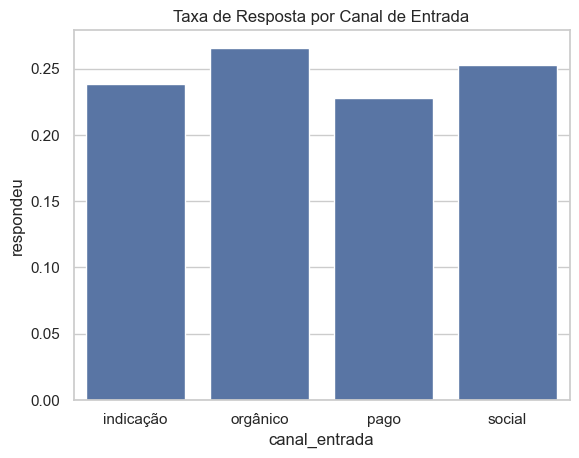

In [33]:
respostas = campanhas.merge(clientes, on='cliente_id')
taxa_resposta = respostas.groupby('canal_entrada')['respondeu'].apply(lambda x: (x == 'sim').mean()).reset_index()
sns.barplot(data=taxa_resposta, x='canal_entrada', y='respondeu')
plt.title('Taxa de Resposta por Canal de Entrada')
plt.show()

### Average length of stay

In [26]:
ultima = transacoes.groupby('cliente_id')['data'].max().reset_index()
df_tempo = clientes.merge(ultima, on='cliente_id')
df_tempo['tempo_ativo'] = (df_tempo['data'] - df_tempo['data_entrada']).dt.days
df_tempo.groupby('canal_entrada')['tempo_ativo'].mean()

canal_entrada
indicação    466.463235
orgânico     473.507463
pago         424.017699
social       444.427350
Name: tempo_ativo, dtype: float64

### Save graphs


In [ ]:
rfm.to_csv('../insights/segment.csv', index=False)
